Search Efficient + Spline (Example)
====

**Conexión por SSH**

In [16]:
import ibex
ssh = ibex.connect("158.251.88.197")

login: iaraya
pass: ········


In [2]:
ibex.get_instances()

binh.txt
cf3-3.txt
cf3-5.txt
ctp1-3.txt
ctp1-5.txt
ctp2-3.txt
ctp2-5.txt
ctp6-3.txt
ctp6-4.txt
ctp7-4.txt
ctp7-5.txt
kim.txt
mop-10.txt
mop-13.txt
mop-7.txt
nbi.txt
osy.txt
sr.txt
tan.txt
test.txt
wb.txt


**Interpolación usando spline y search_efficient**

inital box: [0.0, 40.0] [0.0, 40.0]


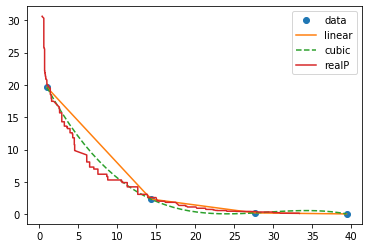

In [17]:
from scipy.interpolate import interp1d #spline
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

instance = "mop-7.txt"
npoints = 4
prec_se = 1e-1 #precisión para search_efficient
prec = 2 #precisión para el solver

# We obtain the initial box
b1 = ibex.search_efficient(instance, [-1e8,1e8,-1e8,1e8], mode="minf1", prec=prec_se)[1]
b2 = ibex.search_efficient(instance, [-1e8,1e8,-1e8,1e8], mode="minf2", prec=prec_se)[1]
y1 = [b1[0], b2[0]]
y2 = [b2[1], b1[1]]
print("inital box:", y1,y2)


x = np.linspace(y1[0], y1[1], num=npoints, endpoint=True)
y = np.zeros(npoints)
xpoints = []
i = 0
for a in x:
    xpoint, ypoint, time = ibex.search_efficient(instance, [a-10*prec_se,a+10*prec_se,y2[0],y2[1]], mode="minf2", prec=prec_se)
    xpoints.append(xpoint)
    
    x[i] = ypoint[0]; y[i] = ypoint[1]
    i+=1

f = interp1d(x, y) #linear
f2 = interp1d(x, y, kind='cubic')

xsol, ysol = ibex.solve(instance, prec=prec)

xnew = np.linspace(x[0], x[-1], num=41, endpoint=True)

#plot
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--', xsol, ysol, '-')
plt.legend(['data', 'linear', 'cubic', 'realP'], loc='best')
plt.show()

Búsqueda de puntos eficientes
--

**1. Cálculo del punto a interpolar**

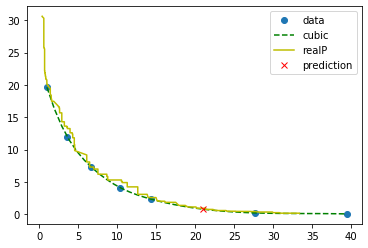

In [34]:
max_area=0;
for i in range(len(x)-1):
    area = (x[i+1]-x[i])*(y[i]-y[i+1])
    if max_area < area:
        max_area=area
        best_i = i
xmid = np.array((x[best_i]+x[best_i+1])/2) #punto a interpolar

f2 = interp1d(x, y, kind='cubic')

plt.plot(x, y, 'o', xnew, f2(xnew), 'g--', xsol, ysol, 'y-', xmid, f2(xmid), 'rx')
plt.legend(['data', 'cubic', 'realP', 'prediction'], loc='best')
plt.show()

**2. Creación de small_box**

In [35]:
h = 0.01*(y2[1]-y2[0]) #altura de caja
w = 0.01*(y1[1]-y1[0]) #ancho de caja

small_box = [xmid-w/2, xmid+w/2, f2(xmid)-h/2, f2(xmid)+h/2]

###small box on x (esto es nuevo!)###
#Hace falta actualizar xpoints en cada iteración!
#box_x = []
#for i in range(len(xpoints[0])):
#    box_x.append(np.minimum(xpoints[best_i][i],xpoints[best_i+1][i]))
#    box_x.append(np.maximum(xpoints[best_i][i],xpoints[best_i+1][i]))
#####
    
#plot
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Create a Rectangle patch
rect = patches.Rectangle((xmid-w/2,f2(xmid)-h/2),w,h,linewidth=2,edgecolor='r',facecolor='r')

# Add the patch to the Axes
ax.add_patch(rect)
plt.plot(x, y, 'o', xsol, ysol, 'y-')
plt.legend(['data', 'realP', 'smallbox'], loc='best'); plt.show()

IndexError: list index out of range

**3. Buscando en small_box**

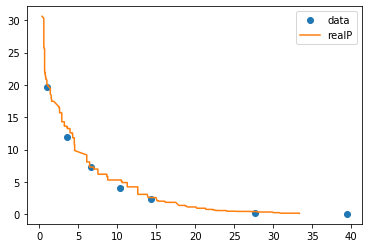

time (search efficient): 11.5263530000001


In [31]:
aux_x, aux_y, time =  ibex.search_efficient(instance, small_box, mode="efficient", prec=prec_se)#, box_x=box_x)
xx, yy = aux_y

if xx==np.inf or yy==np.inf:
    print("no solution found")
else:
    x_=np.append(x,xx); x_.sort() #y1
    y_=np.append(y,yy); y_[::-1].sort() #y2
    
    fig,ax = plt.subplots(1)
    rect = patches.Rectangle((xmid-w/2,f2(xmid)-h/2),w,h,linewidth=1,edgecolor='y',facecolor='none')
    ax.add_patch(rect)
    plt.plot(x_, y_, 'o', xsol, ysol, '-')
    plt.legend(['data', 'realP'], loc='best')
    plt.show()

print("time (search efficient):", time)

**4. Actualizar vectores. Luego, volver a 1**

In [33]:
x=x_; y=y_